#### Load necessary packages

In [1]:
import os
import sys
sys.path.insert(0,'../../mocsy')

In [2]:
import mocsy
from mocsy import mvars
import numpy as np
import random
from tqdm import tqdm
import matplotlib.pyplot as plt

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

#### Create pH training data with mocsy routine 

In [4]:
def extend(number, template):
    """
    helper function allowing calc_pH to work on floats and arrays.
    """
    template_type = "array" if isinstance(template, np.ndarray) else "float"
    if template_type == "array":
        return number * np.ones(template.shape)
    elif template_type == "float":
        return number

def calc_pH(alk, dic, tem, sal, sil, phos):
    """
    input units
    alk in mol / kg
    dic in mol / kg
    tem in °C
    sal in PSU
    sil in mol / kg
    phos in mol / kg
    """
    return mvars(alk=alk,
                     dic=dic,
                     temp=tem,
                     sal=sal,
                     sil=sil,
                     phos=phos,
                     patm=extend(1, alk),
                     depth=extend(5, alk),
                     lat=extend(np.nan, alk),
                     optcon='mol/kg',
                     optt='Tpot',
                     optp='db',
                     optk1k2='l',
                     optb='u74',
                     optkf='pf',
                     opts='Sprc')[0]

In [5]:
np.random.seed(0)
samples = {"alk":[], "dic":[], "tem":[], "sal":[],
           "sil":[], "phos":[]}
sample_size = 6000_000

alk_range = [1000e-6, 3000e-6]
dic_range = [1000e-6, 3000e-6]
tem_range = [-2, 35]
sal_range = [10, 50]
sil_range = [0, 134e-6]
phos_range = [0, 4e-6]

for i in range(sample_size):
    samples["alk"].append(np.random.uniform(low=alk_range[0], high=alk_range[1]))
    samples["dic"].append(np.random.uniform(low=dic_range[0],
                                            high=samples["alk"][-1]))
    samples["tem"].append(np.random.uniform(low=tem_range[0], high=tem_range[1]))
    samples["sal"].append(np.random.uniform(low=sal_range[0], high=sal_range[1]))
    samples["sil"].append(np.random.uniform(low=sil_range[0], high=sil_range[1]))
    samples["phos"].append(np.random.uniform(low=phos_range[0], high=phos_range[1]))

for key in samples.keys():
    samples[key] = np.array(samples[key])

In [8]:
sample_ph = calc_pH(samples["alk"], samples["dic"], samples["tem"],
                        samples["sal"], samples["sil"], samples["phos"])

In [9]:
print("Median of pH across sample: ", np.median(sample_ph))
print("Mean of pH across sample: ", np.mean(sample_ph))
print("Minimum of pH across sample: ", np.min(sample_ph))
print("Maximum of pH across sample: ", np.max(sample_ph))

Median of pH across sample:  8.445730749960495
Mean of pH across sample:  8.494317602979947
Minimum of pH across sample:  7.028496413946809
Maximum of pH across sample:  11.476400987811132


In [10]:
ntrain = 5000_000

train_ph, valid_ph = np.split(sample_ph, [ntrain])
train_samples = {key: samples[key][:ntrain] for key in samples}
valid_samples = {key: samples[key][ntrain:] for key in samples}

In [11]:
sample_means = {"alk":(alk_range[0] + alk_range[1]) / 2,
                 "dic":dic_range[0] + (dic_range[1] - dic_range[0]) / 4,
                 "tem":(tem_range[0] + tem_range[1]) / 2,
                 "sal":(sal_range[0] + sal_range[1]) / 2,
                 "sil":(sil_range[0] + sil_range[1]) / 2,
                 "phos":(phos_range[0] + phos_range[1]) / 2}

sample_stds = {"alk":(alk_range[1] - alk_range[0]) / np.sqrt(12),
                 "dic":(dic_range[1] - dic_range[0]) * np.sqrt(7 / 144),
                 "tem":(tem_range[1] - tem_range[0]) / np.sqrt(12),
                 "sal":(sal_range[1] - sal_range[0]) / np.sqrt(12),
                 "sil":(sil_range[1] - sil_range[0]) / np.sqrt(12),
                 "phos":(phos_range[1] - phos_range[0]) / np.sqrt(12)}


print("Some statistics:")
for key in train_samples.keys():
    print("Mean for {} samples: {:.6e}, expected: {:.6e}".format(
    key, np.mean(train_samples[key]), sample_means[key]))
    print("Std for {} samples: {:.6e}, expected: {:.6e}".format(
    key, np.std(train_samples[key]), sample_stds[key]))
    print("-----")

Some statistics:
Mean for alk samples: 2.000055e-03, expected: 2.000000e-03
Std for alk samples: 5.773906e-04, expected: 5.773503e-04
-----
Mean for dic samples: 1.500187e-03, expected: 1.500000e-03
Std for dic samples: 4.410831e-04, expected: 4.409586e-04
-----
Mean for tem samples: 1.649846e+01, expected: 1.650000e+01
Std for tem samples: 1.068605e+01, expected: 1.068098e+01
-----
Mean for sal samples: 2.999500e+01, expected: 3.000000e+01
Std for sal samples: 1.154547e+01, expected: 1.154701e+01
-----
Mean for sil samples: 6.697189e-05, expected: 6.700000e-05
Std for sil samples: 3.870030e-05, expected: 3.868247e-05
-----
Mean for phos samples: 1.999234e-06, expected: 2.000000e-06
Std for phos samples: 1.154432e-06, expected: 1.154701e-06
-----


#### Normalize samples

In [12]:
train_features_normalized = np.concatenate([(train_samples[key][:, np.newaxis]
                                             - sample_means[key]) / sample_stds[key]
                                 for key in ["alk", "dic", "tem", "sal", "sil", "phos"]],
                                          axis=1)

valid_features_normalized = np.concatenate([(valid_samples[key][:, np.newaxis]
                                             - sample_means[key]) / sample_stds[key]
                                 for key in ["alk", "dic", "tem", "sal", "sil", "phos"]],
                                          axis=1)
    
print(train_features_normalized.shape)

(5000000, 6)


In [13]:
print("Verify that data is normalized.")
print(np.mean(train_features_normalized, axis=0))
print(np.std(train_features_normalized, axis=0))

Verify that data is normalized.
[ 9.47580989e-05  4.23186847e-04 -1.44276512e-04 -4.32910793e-04
 -7.26599596e-04 -6.63078680e-04]
[1.00006983 1.00028241 1.00047477 0.99986704 1.00046103 0.99976755]


#### Define neural network and training procedure

In [14]:
class MLP(nn.Module):
    def __init__(self, input_size, hidden_size_1, hidden_size_2, hidden_size_3, output_size):
        super().__init__()
        self.device = torch.device("cuda")
        self.linear1 = nn.Linear(input_size, hidden_size_1, device=self.device)
        self.linear2 = nn.Linear(hidden_size_1, hidden_size_2, device=self.device)
        self.linear3 = nn.Linear(hidden_size_2, hidden_size_3, device=self.device)
        self.linear4 = nn.Linear(hidden_size_3, output_size, device=self.device)

    def forward(self, x):
        x = x.to(self.device)
        x = F.elu(self.linear1(x))
        x = F.elu(self.linear2(x))
        x = F.elu(self.linear3(x))
        x = F.elu(self.linear4(x))
        return x

    def save(self, file_name='model.pth'):
        model_folder_path = '../models'
        if not os.path.exists(model_folder_path):
            os.makedirs(model_folder_path)

        file_name = os.path.join(model_folder_path, file_name)
        torch.save(self.state_dict(), file_name)

loss_function = nn.MSELoss()

In [15]:
model = MLP(6, 160, 160, 160, 1)
print(model)
pytorch_total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print("Number of trainable parameters in the model:", pytorch_total_params)

MLP(
  (linear1): Linear(in_features=6, out_features=160, bias=True)
  (linear2): Linear(in_features=160, out_features=160, bias=True)
  (linear3): Linear(in_features=160, out_features=160, bias=True)
  (linear4): Linear(in_features=160, out_features=1, bias=True)
)
Number of trainable parameters in the model: 52801


In [16]:
def training_dataloader(features, labels, batch_size):
    ntrain = len(labels)
    nbatch = ntrain // batch_size
    indices = np.arange(ntrain, dtype=int)
    random.shuffle(indices)
    batch_indices = np.split(indices[:nbatch * batch_size], nbatch)
    batch_data = [(torch.from_numpy(np.take(features, ind, axis=0).astype("float32")),
                   torch.from_numpy(np.take(labels, ind).astype("float32"))) for ind in batch_indices]
    return batch_data

In [17]:
def train_one_epoch(optimizer):
    running_loss = 0. # running loss over all batches in the epoch
    
    training_data = training_dataloader(train_features_normalized,
                                        train_ph, batch_size)
    
    for batch in training_data:
        features, labels = batch
        optimizer.zero_grad()
        outputs = torch.squeeze(model(features))
        loss = loss_function(outputs, labels.to(torch.device("cuda")))
        loss.backward()
        optimizer.step()
        
        running_loss += loss.detach().cpu().item()

    ntrain = len(train_ph)
    nbatch = ntrain // batch_size

    return running_loss / nbatch

In [21]:
def calc_gammar(reduction_factor, nepochs):                                                                                                                                                                       
    return reduction_factor**(1 / nepochs)

def train(batch_size, base_learning_rate, gamma, n_epochs):
    train_stats = {"train_loss":[], "valid_loss":[], "learn_rate":[]}

    optimizer = optim.Adam(model.parameters(), lr=base_learning_rate)
    scheduler = optim.lr_scheduler.ExponentialLR(optimizer,
                                                 gamma=gamma)

    pbar = tqdm(range(n_epochs), postfix=f'epoch 0/{n_epochs}')
    for epoch in pbar:

        model.train()
        train_loss_epoch = train_one_epoch(optimizer)

        model.eval()
        with torch.no_grad():
            valid_outputs = torch.squeeze(model(
                torch.from_numpy(valid_features_normalized.astype("float32"))))
            valid_loss_epoch = loss_function(valid_outputs, 
                                             torch.from_numpy(valid_ph).to(torch.device("cuda"))
                                            ).detach().cpu().item()
        
        train_stats["train_loss"].append(train_loss_epoch)
        train_stats["valid_loss"].append(valid_loss_epoch)
        lr = scheduler.get_last_lr()[0]
        train_stats["learn_rate"].append(lr)

        scheduler.step()

        pbar.set_postfix({'epoch': f'{epoch+1}/{n_epochs}',
                          'train_loss':f'{train_loss_epoch:.4e}',
                          'valid_loss':f'{valid_loss_epoch:.4e}',
                          'learn_rate':f'{lr:.4e}'})

    return train_stats

#### Train neural network with pytorch

In [22]:
batch_size = 1000
base_learning_rate = 1e-3
gamma = calc_gammar(0.1, 5000)
n_epochs = 10000
train_stats = train(batch_size, base_learning_rate, gamma, n_epochs)

100%|████████████████████████████████████████████████████████████████████████████| 10000/10000 [14:00:21<00:00,  5.04s/it, epoch=10000/10000, train_loss=7.4869e-09, valid_loss=6.8060e-09, learn_rate=1.0005e-05]


In [23]:
model.save("pH_model_160x3_elu_10000epo.pth")

Text(0, 0.5, 'Mean squared error')

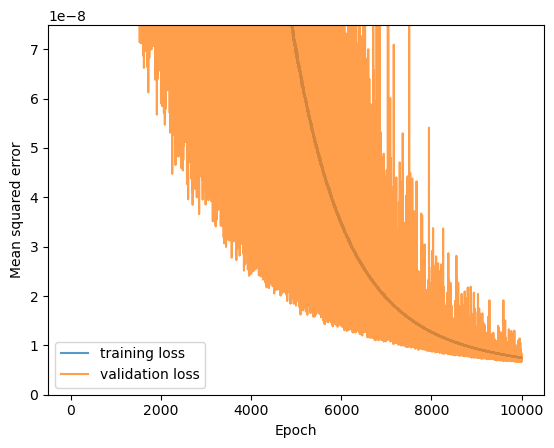

In [24]:
plt.plot(train_stats["train_loss"], label="training loss", alpha=0.75)
plt.plot(train_stats["valid_loss"], label="validation loss", alpha=0.75)
plt.legend()
plt.ylim([0, train_stats["train_loss"][-1] * 10])
plt.xlabel("Epoch")
plt.ylabel("Mean squared error")

In [25]:
print("Some tests of model performance")
random_indices = np.random.randint(ntrain, size=10, dtype=int)

model.eval()
with torch.no_grad():
    for ind in random_indices:
        print("Index: ", ind)
        print("{:.4f}".format(train_ph[ind]))
        print(model(torch.from_numpy(train_features_normalized[ind, :].astype("float32"))))
        print("-----")

Some tests of model performance
Index:  2486469
9.7567
tensor([9.7568], device='cuda:0')
-----
Index:  889830
8.0462
tensor([8.0462], device='cuda:0')
-----
Index:  1523244
8.3746
tensor([8.3746], device='cuda:0')
-----
Index:  4919512
8.1716
tensor([8.1716], device='cuda:0')
-----
Index:  772012
8.8202
tensor([8.8201], device='cuda:0')
-----
Index:  42812
7.5389
tensor([7.5390], device='cuda:0')
-----
Index:  4554809
8.4947
tensor([8.4948], device='cuda:0')
-----
Index:  4297866
7.7048
tensor([7.7047], device='cuda:0')
-----
Index:  1591483
9.9566
tensor([9.9569], device='cuda:0')
-----
Index:  3986147
7.8665
tensor([7.8666], device='cuda:0')
-----


In [26]:
def MSE(x, y): # define MSE for offline calculations on numpy arrays
    return np.sum((x-y)**2)/len(x)

In [27]:
model.eval()
with torch.no_grad():
    model_output_after_training = model(torch.from_numpy(
        valid_features_normalized.astype("float32"))).detach().cpu().numpy().squeeze()

In [28]:
print("MSE (for consistency check): ", MSE(valid_ph, model_output_after_training))
print("RMSE: ", np.sqrt(MSE(valid_ph, model_output_after_training)))
print("Maximum absolute deviation: ", np.max(np.abs(model_output_after_training-valid_ph)))
print("99.9th percentile of absolute deviation (1000 val's larger): ",
      np.percentile(np.abs(model_output_after_training-valid_ph), q=99.9))
print("99.99th percentile of absolute deviation (100 val's larger): ",
      np.percentile(np.abs(model_output_after_training-valid_ph), q=99.99))
print("99.999th percentile of absolute deviation (10 val's larger): ",
      np.percentile(np.abs(model_output_after_training-valid_ph), q=99.999))

MSE (for consistency check):  6.8060390262927885e-09
RMSE:  8.249872136156286e-05
Maximum absolute deviation:  0.004416247278518526
99.9th percentile of absolute deviation (1000 val's larger):  0.0003892787003084829
99.99th percentile of absolute deviation (100 val's larger):  0.0005855108139358614
99.999th percentile of absolute deviation (10 val's larger):  0.0010492375275132056
